# Linear regression of Plastechron Index
Author: Vy T. Nguyen<br>
Last Edited: 12/3/2018

## Purpose
To fit plastechron indexes for replication of a plot to a linear model and find the average slope for each plot and genotype for each season of the Citra 2016 experiment.


In [1]:
rm(list = ls())

library(plyr)
library(dplyr)
library(ggplot2)

setwd(paste('C:/Users/Vy/Documents'))
wd <- getwd()
setwd(paste(wd,'work','Data','Citra2016', sep = '/'))

data <- read.csv('pIndex_citra 2016.csv', header = T, na.strings = c('NA', '', '#NUM!', '#REF!', '#VALUE!'), stringsAsFactors=T)
geno <- read.csv('PtoGen.csv', header = T, stringsAsFactors=T)

#head(data)
#tail(data)

#head(geno)
#tail(geno)
#length(unique(geno[grep('RIJC',geno$geno), 'geno']))

#length(unique(geno[grep('TM',geno$geno), 'geno']))



Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
PIT <- data[c('Plot.ID', 'site', 'Plant.ID', 'PIT1', 'PIT2', 'PIT3', 'T1..DAP.', 'T2.DAP.', 'T3.DAP.')]
#head(PIT)

In [3]:
pit1 <- data[c('Plot.ID', 'Plant.ID', 'PIT1', 'T1..DAP.', 'site')]
colnames(pit1) <- c('plot', 'rep', 'PI', 'DAP', 'site')

pit2 <- data[c('Plot.ID', 'Plant.ID', 'PIT2', 'T2.DAP.', 'site')]
colnames(pit2) <- c('plot', 'rep', 'PI', 'DAP', 'site')

pit3 <- data[c('Plot.ID', 'Plant.ID', 'PIT3', 'T3.DAP.', 'site')]
colnames(pit3) <- c('plot', 'rep', 'PI', 'DAP', 'site')

pit <- rbind(pit1, pit2)
pit <- rbind(pit, pit3)

noNApit <- pit[is.na(pit$PI)==F & is.na(pit$DAP)==F,]

#head(noNApit)
#tail(noNApit)
#nrow(pit)
#nrow(noNApit)

In [4]:
plotPI <- function(x,y, data, fit){
    c <- ggplot(data)
    plot1 <- c + 
      #geom_smooth(aes(x=DAP, y=value), se=F, span=1) +
      geom_point(aes(x=x, y=y))+
      #facet_grid(.~plot) +
      coord_cartesian(ylim = c()) + 
      theme() +
      labs(x = 'Days After Planting (DAP)', y = paste('Plastechron Index (PI)'), 
            title = paste('Plot', data$plot,'Season', data$site, 'Plant', data$rep, sep=' ') ) + 
      theme_bw() + 
      scale_alpha(guide = 'none')  +
      geom_line(aes(x=x, y=predict(fit), color='red'))
    
    print(plot1)
}

In [5]:
findSlope <- function(x){
    #print(x)
    DAP  <- as.numeric(x[,'DAP'])
    PI <- as.numeric(x[,'PI'])
    
    fit <- lm(PI ~ DAP, data=x, na.action=na.omit)
    
    result <-  data.frame('slope' = summary(fit)$coefficient[2], 
                          'inter' = summary(fit)$coefficient[1],
                          'sd' = sd(x$PI),
                          'plot' = x[1,'plot'], 
                          'rep' = x[1,'rep'],
                         'site' = x[1,'site'],
                         'r2' = summary(fit)$r.squared)
    #plotPI(DAP,PI,x,fit)
    
    return(result)
}

In [6]:
byPlot = by(noNApit, INDICES=list(noNApit$site, noNApit$plot, noNApit$rep), FUN=findSlope)

results <- do.call("rbind", byPlot)

In [7]:
#head(results[results$site==2,])
#nrow(results)
#factor(results$site)

In [8]:
resultsRIL <- merge(results, geno, by = 'plot', all.x=T)

meanRIL <- aggregate(resultsRIL[,c('slope', 'inter', 'r2')], by = list(resultsRIL$geno, resultsRIL$site), FUN=mean, na.action=na.rm)
colnames(meanRIL)[1:2] <- c('geno', 'site')

#head(meanRIL[meanRIL$site==2,])


# Results and Discussion
## All Lines

In [9]:
seasonResults <- aggregate(results[c('slope', 'inter', 'r2')], by = list(results$site), FUN =mean, na.rm=T)
colnames(seasonResults)[1] = 'site'
seasonResults

site,slope,inter,r2
1,0.2794118,-2.603380,0.9559936
2,0.3011524,-2.300145,0.9379967


Season 1 of Citra 2016 had a Plastechron slope over time of 0.279 while season 2 had a slope of 0.301 and r-squared values of 0.956 and 0.938. When performing a t-test between the two seasons, p-value was calculated as 0.0058. Since the p-value was underneath an alpha value of 0.05, it strongly suggests that there is a true difference between the slopes. This suggests that the enviromental differences in the two seasons may play a role in the slope of the plastechron index and therefore the development of the population.

In [10]:
s1Slope <- meanRIL[meanRIL$site==1, 'slope']
s2Slope <- meanRIL[meanRIL$site==2, 'slope']

t.test(s1Slope,s2Slope)


	Welch Two Sample t-test

data:  s1Slope and s2Slope
t = -2.7803, df = 257.4, p-value = 0.005831
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.036922251 -0.006305428
sample estimates:
mean of x mean of y 
0.2794277 0.3010416 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."Warning message:
"Removed 5 rows containing missing values (geom_text)."

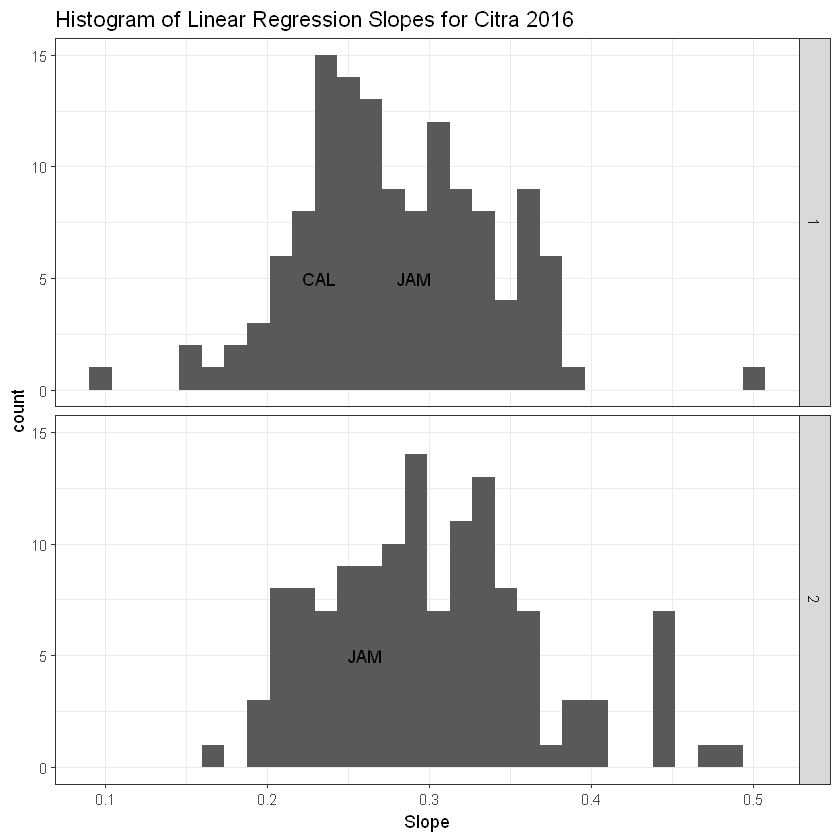

In [11]:
p <- ggplot(meanRIL, aes(label = geno))

plot1 <- p + geom_histogram(aes(x=meanRIL$slope)) +
    coord_cartesian(ylim = c()) + 
    theme() +
    labs( x = paste('Slope'), 
        title = paste('Histogram of Linear Regression Slopes for Citra 2016', sep=' ') ) + 
    theme_bw() + 
    scale_alpha(guide = 'none')+
    facet_grid(rows = vars(meanRIL$site)) +
    geom_text(aes(label = ifelse(meanRIL$geno %in% meanRIL[grep('CAL|JAM', meanRIL$geno),'geno'],
                                 as.character(geno), ''), x = meanRIL$slope, y = 5))

print(plot1)

## RIJC lines


	Welch Two Sample t-test

data:  S1RIJC and S2RIJC
t = -1.8748, df = 206.29, p-value = 0.06224
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0330266491  0.0008309841
sample estimates:
mean of x mean of y 
0.2786220 0.2947198 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 4 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_text)."

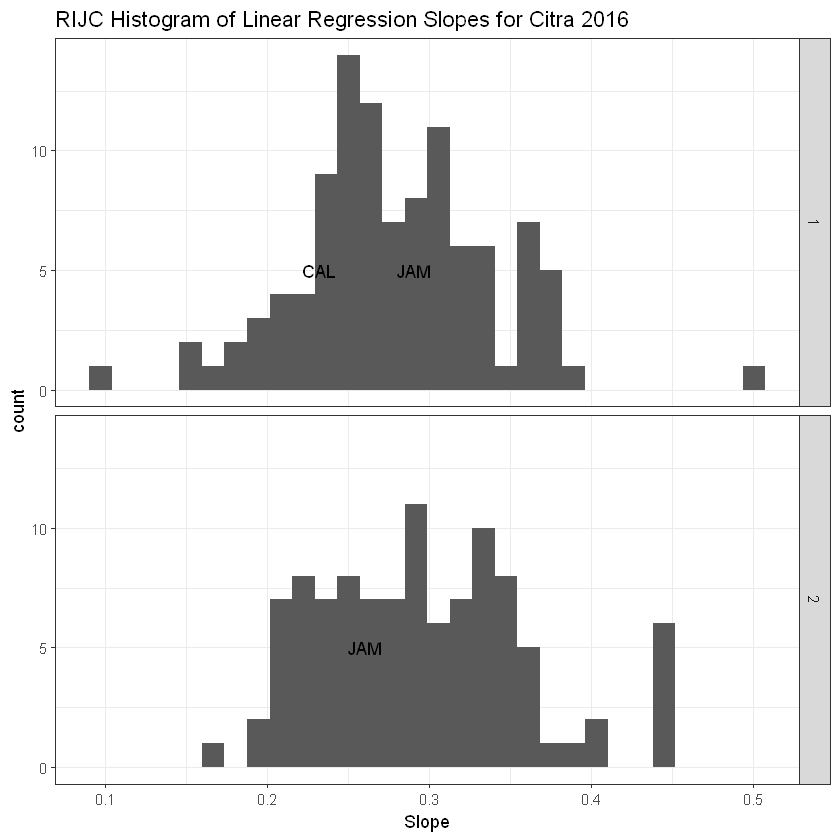

In [12]:
RIJC <- meanRIL[grep('RIJC|CAL|JAM',meanRIL$geno), ]

S1RIJC <- RIJC[RIJC$site==1, 'slope']
S2RIJC <- RIJC[RIJC$site==2, 'slope']

t.test(S1RIJC,S2RIJC)

q <- ggplot(RIJC, aes(label = geno))

plot2 <- q + geom_histogram(aes(x=RIJC$slope)) +
    coord_cartesian(ylim = c()) + 
    theme() +
    labs( x = paste('Slope'), 
        title = paste('RIJC Histogram of Linear Regression Slopes for Citra 2016', sep=' ') ) + 
    theme_bw() + 
    scale_alpha(guide = 'none')+
    facet_grid(rows = vars(RIJC$site)) +
    geom_text(aes(label = ifelse(RIJC$geno %in% RIJC[grep('CAL|JAM', RIJC$geno),'geno'],
                                 as.character(geno), ''), x = RIJC$slope, y = 5))

print(plot2)

## Select Lines

In [13]:
selectLines <- meanRIL[grep('RIJC016|RIJC208|RIJC217|RIJC223|CAL|JAM',meanRIL$geno), ]

#selectLines <- selectLines[order(selectLines$geno),]
write.csv(selectLines, 'selectLines.csv')

In [16]:
head(results)
selectLines

slope,inter,sd,plot,rep,site,r2
0.3078369,-3.502816,0.9241048,1,P1,1,0.9987148
0.3389771,-4.068113,1.0170562,10,P1,1,0.9997544
0.1757521,-1.347403,0.4465611,100,P1,1,0.9810060
0.2948755,-3.439955,0.7424427,101,P1,1,0.9990425
0.3302589,-3.818027,0.8385964,102,P1,1,0.9822802
0.2404295,-2.695972,0.6052733,103,P1,1,0.9993202


,geno,site,slope,inter,r2
3,CAL,1,0.2322145,-1.2012999,0.9498740
135,CAL,2,NaN,-1.6416875,0.9081736
8,JAM,1,0.2910273,-2.9956562,0.8819519
140,JAM,2,0.2603627,-1.9718347,0.9858628
22,RIJC016,1,0.3404150,-4.0097929,0.9905355
154,RIJC016,2,0.2479945,-1.8694633,0.9808753
64,RIJC208,1,0.2711636,-2.4496404,0.9835010
196,RIJC208,2,0.2961063,-2.4463351,0.9901415
67,RIJC217,1,0.2346858,-1.7570314,0.9799675
199,RIJC217,2,0.3398284,-3.3931981,0.9385951
